This notebook performs **exploratory data analysis (EDA)** on the Europe e‑waste recycling panel built in the wrangling step. 
It follows the Springboard rubric: data profiles, visualizations, relationships/correlations, feature selection reasoning, and clear presentation.

**Inputs expected (from wrangling step):**
- `data_clean/eu_panel_clean.csv` — tidy country–year panel with columns:
  - `country`, `country_code`, `year`, `ewaste_recycling_rate_pct`, `population`, `gdp_current_usd`
- `data_clean/eu_recycling_rate_timeseries.csv` — EU aggregates:
  - `year`, `eu_recycling_rate_pct_popweighted`, `eu_recycling_rate_pct_mean`

In [1]:
# --- Imports & Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Style & display
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
plt.rcParams["figure.figsize"] = (9, 5)

# Reproducibility (for any randomized steps later)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# --- Load Data
PANEL_PATH = "data_clean/eu_panel_clean.csv"
EU_SERIES_PATH = "data_clean/eu_recycling_rate_timeseries.csv"

panel = pd.read_csv(PANEL_PATH)
eu_series = pd.read_csv(EU_SERIES_PATH)

print("Panel shape:", panel.shape)
print("EU series shape:", eu_series.shape)
panel.head()

Panel shape: (271, 6)
EU series shape: (11, 3)


,country,country_code,year,ewaste_recycling_rate_pct,population,gdp_current_usd
0,Austria,AUT,2010,79.9,8363404.0,3.898278e+11
1,Austria,AUT,2011,81.5,8391643.0,4.289547e+11
2,Austria,AUT,2012,80.0,8429991.0,4.067505e+11
3,Austria,AUT,2013,79.0,8479823.0,4.265805e+11
4,Austria,AUT,2014,79.6,8546356.0,4.385560e+11


## 1) Data Profiles & Schema Checks
We begin by profiling the dataset to confirm columns, dtypes, ranges, and missingness.

In [3]:
# --- Quick schema + summary helpers
def profile(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("columns:", df.columns.tolist())
    print(df.dtypes)
    print("\nMissing values per column:\n", df.isna().sum())

profile(panel, "EU Panel (country-year)")
print("\nDescribe (key numeric columns):")
display(panel[["ewaste_recycling_rate_pct", "population", "gdp_current_usd"]].describe())

# Year range and entities
print("\nYears:", int(panel['year'].min()), "→", int(panel['year'].max()))
print("Countries:", panel['country_code'].nunique())


=== EU Panel (country-year) ===
shape: (271, 6)
columns: ['country', 'country_code', 'year', 'ewaste_recycling_rate_pct', 'population', 'gdp_current_usd']
country                       object
country_code                  object
year                           int64
ewaste_recycling_rate_pct    float64
population                   float64
gdp_current_usd              float64
dtype: object

Missing values per column:
 country                      0
country_code                 0
year                         0
ewaste_recycling_rate_pct    0
population                   0
gdp_current_usd              0
dtype: int64

Describe (key numeric columns):


,ewaste_recycling_rate_pct,population,gdp_current_usd
count,271.000000,2.710000e+02,2.710000e+02
mean,82.546273,1.574308e+07,5.580901e+11
std,7.584481,2.186150e+07,9.021406e+11
min,51.000000,3.602200e+04,5.082337e+09
25%,79.450000,2.062756e+06,5.010176e+10
50%,83.100000,6.894139e+06,2.132989e+11
75%,86.700000,1.130281e+07,5.017174e+11
max,122.800000,8.290578e+07,4.052008e+12



Years: 2010 → 2020
Countries: 31


## 2) Distributions & Completeness
We inspect the distribution of recycling rates across all country–year observations and quantify missingness coverage by country.


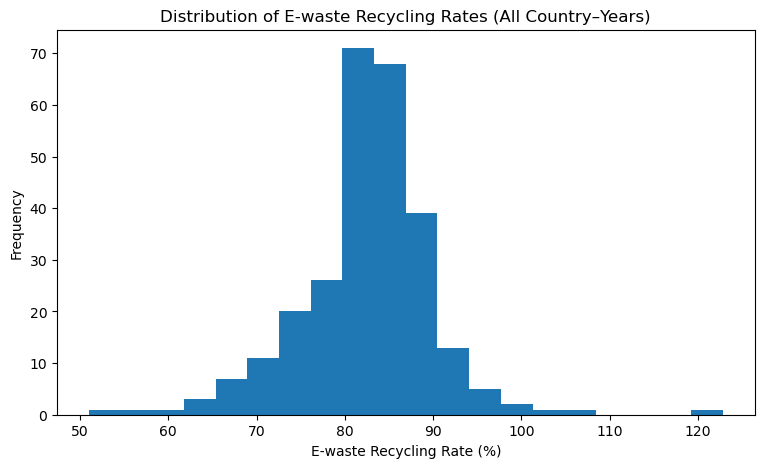

In [5]:
# Histogram of recycling rate (%)
vals = panel["ewaste_recycling_rate_pct"].dropna().values
plt.figure()
plt.hist(vals, bins=20)
plt.xlabel("E-waste Recycling Rate (%)")
plt.ylabel("Frequency")
plt.title("Distribution of E-waste Recycling Rates (All Country–Years)")
plt.show()

,country_code,country,n_years
14,HUN,Hungary,11
20,LUX,Luxembourg,11
16,ISL,Iceland,10
0,AUT,Austria,9
1,BEL,Belgium,9
2,BGR,Bulgaria,9
4,CZE,Czechia,9
6,DNK,Denmark,9
8,EST,Estonia,9
9,FIN,Finland,9


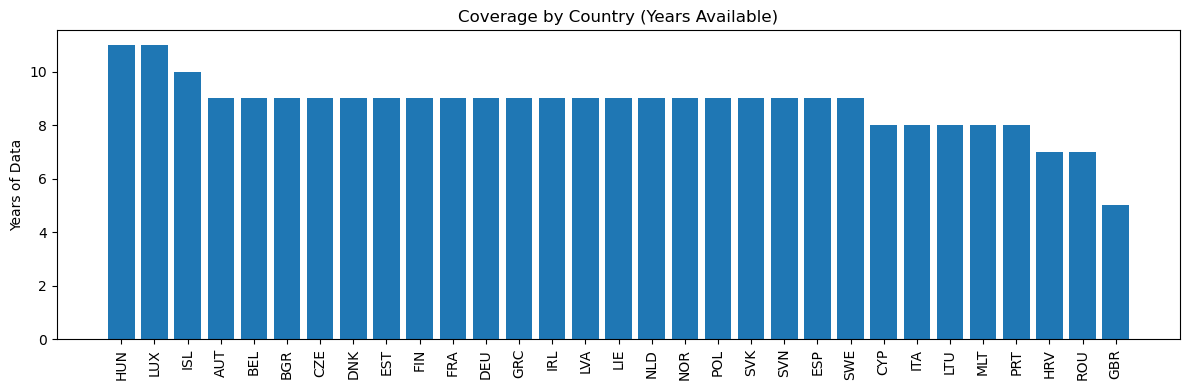

In [6]:
# Coverage: number of years available per country
coverage = (panel.groupby(['country_code','country'])['year']
            .nunique()
            .rename('n_years')
            .reset_index()
            .sort_values(['n_years', 'country'], ascending=[False, True]))
display(coverage.head(15))

# Bar chart of coverage
plt.figure(figsize=(12,4))
plt.bar(coverage['country_code'], coverage['n_years'])
plt.xticks(rotation=90)
plt.ylabel("Years of Data")
plt.title("Coverage by Country (Years Available)")
plt.tight_layout()
plt.show()



## 3) EU Trend: Mean vs Population-Weighted
We compare the simple mean (each country equal) vs a population-weighted rate (large countries count more). Divergence between the two indicates whether performance of populous countries differs from smaller ones.

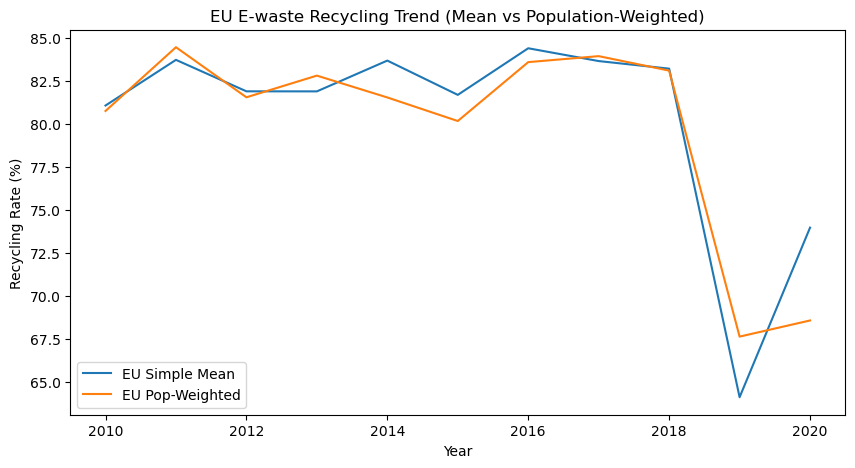

In [14]:
# EU trend lines
plt.figure(figsize=(10,5))
plt.plot(eu_series["year"], eu_series["eu_recycling_rate_pct_mean"], label="EU Simple Mean")
plt.plot(eu_series["year"], eu_series["eu_recycling_rate_pct_popweighted"], label="EU Pop-Weighted")
plt.xlabel("Year")
plt.ylabel("Recycling Rate (%)")
plt.title("EU E-waste Recycling Trend (Mean vs Population-Weighted)")
plt.legend()
plt.show()

From 2010 to around 2018, EU e-waste recycling rates remained relatively stable, fluctuating between roughly 80–85% depending on the year. The population-weighted trend sits slightly below the simple mean in most years, which indicates that larger countries (e.g., Germany, France, Poland) tend to have slightly lower recycling rates on average compared to smaller, high-performing countries (e.g., Nordic states). In other words, smaller countries contribute to lifting the EU-wide average, while bigger countries pull the population-weighted rate downward.
However, there is a sharp drop between 2018 and 2019, seen in both trend lines. This is not consistent with a sudden real-world collapse in recycling systems; instead, it likely reflects changes in reporting coverage or classification methodology in the OWID/UN data series (or missing observations for some previously well-reporting countries). The partial rebound in 2020 suggests that data completeness, rather than actual system performance, contributes to this visible dip.
Overall, the long-run trend suggests steady but not strongly improving recycling performance across Europe in the 2010s, with structural differences between large and small countries persisting across the period.

## 4) Country Rankings (Latest Year)
We rank countries by the most recent year available for each country, then visualize the latest common year across the panel for a fair comparison.


year
2020     3
2019     2
2018    26
2017    30
2016    30
Name: country_code, dtype: int64

Chosen latest common year: 2018


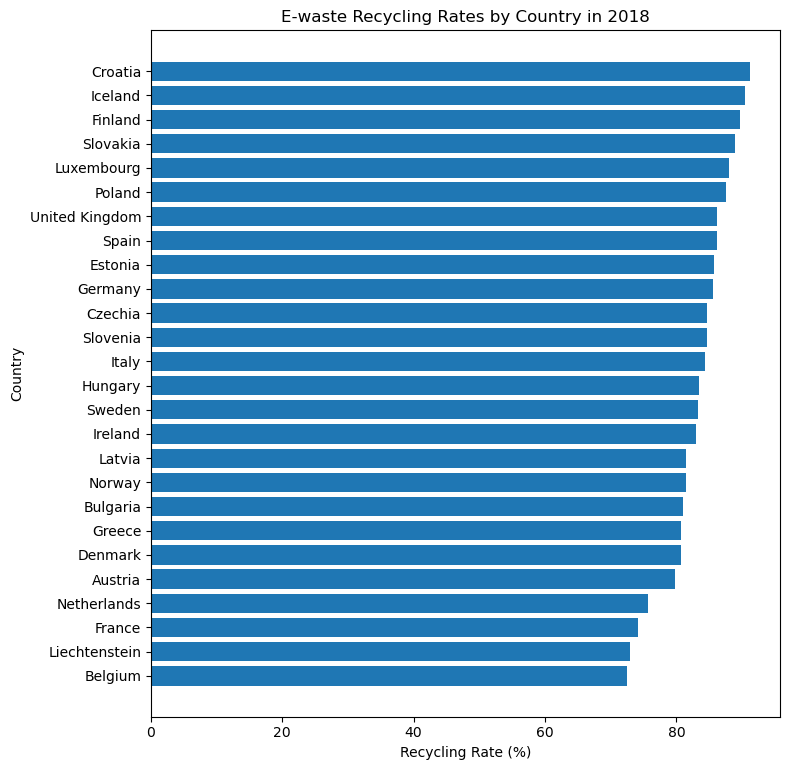

In [15]:
# Determine a latest *common* year across a reasonable share of countries
year_counts = panel.groupby('year')['country_code'].nunique().sort_index(ascending=False)
display(year_counts.head())

# Heuristic: choose the latest year with data for at least 60% of countries
n_ctry = panel['country_code'].nunique()
threshold = max(5, int(0.6 * n_ctry))
candidate_years = year_counts[year_counts >= threshold].index.tolist()
latest_common_year = max(candidate_years) if candidate_years else int(panel['year'].max())
print("Chosen latest common year:", latest_common_year)

latest = (panel[panel["year"] == latest_common_year]
          .sort_values("ewaste_recycling_rate_pct", ascending=False))

# Horizontal bar chart
plt.figure(figsize=(8, max(6, 0.3*len(latest))))
plt.barh(latest["country"], latest["ewaste_recycling_rate_pct"])
plt.xlabel("Recycling Rate (%)")
plt.ylabel("Country")
plt.title(f"E-waste Recycling Rates by Country in {latest_common_year}")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5) Leaders vs Laggards Over Time
We pick the top-5 and bottom-5 countries (by the latest common year) and show their time trends to visualize convergence/divergence.


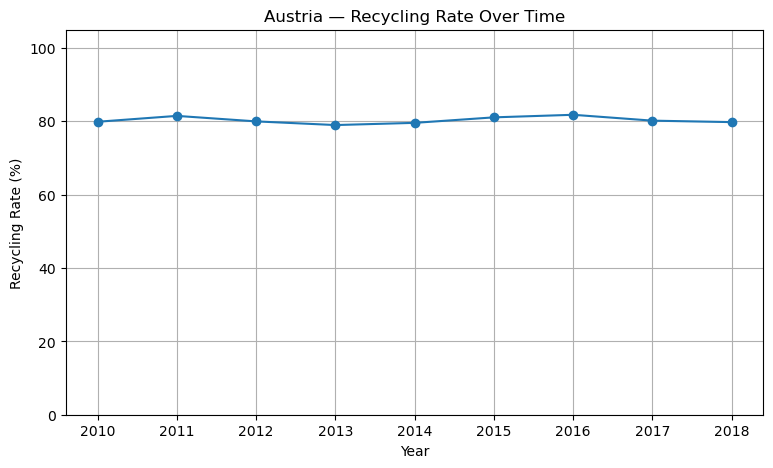

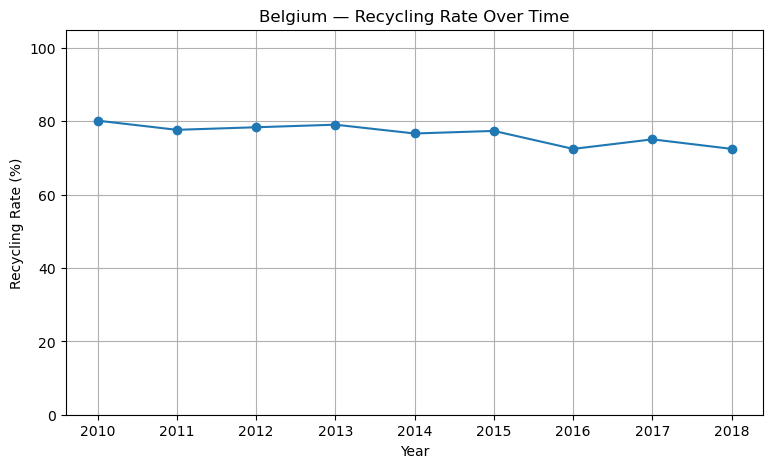

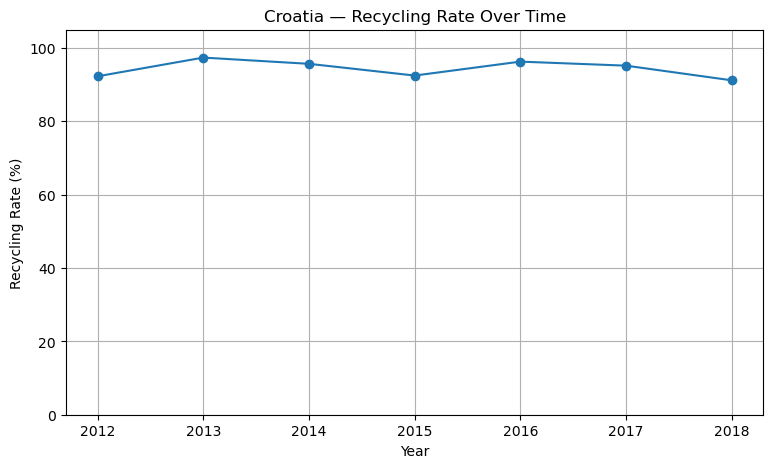

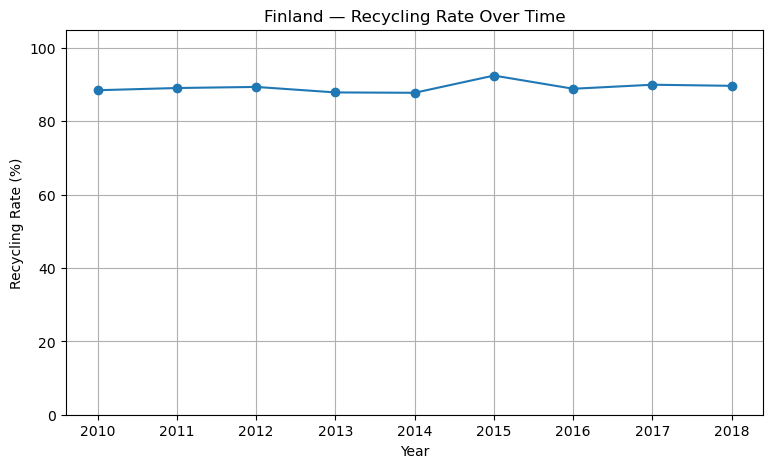

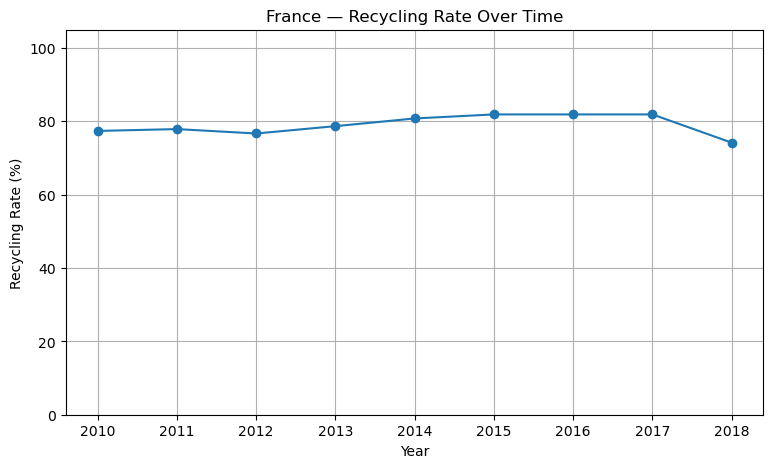

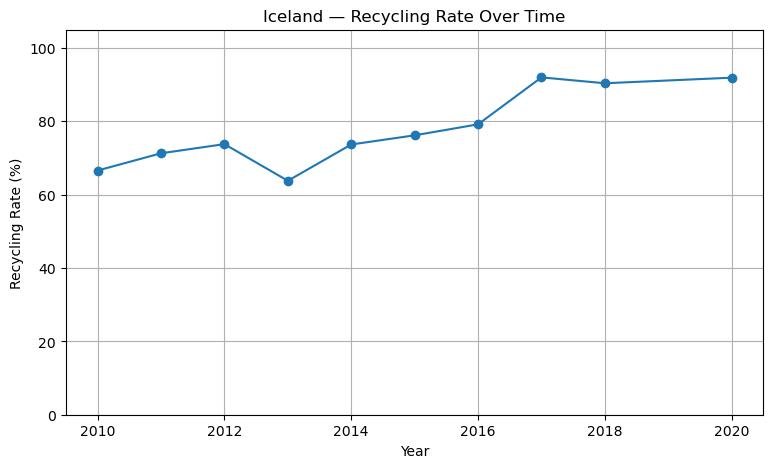

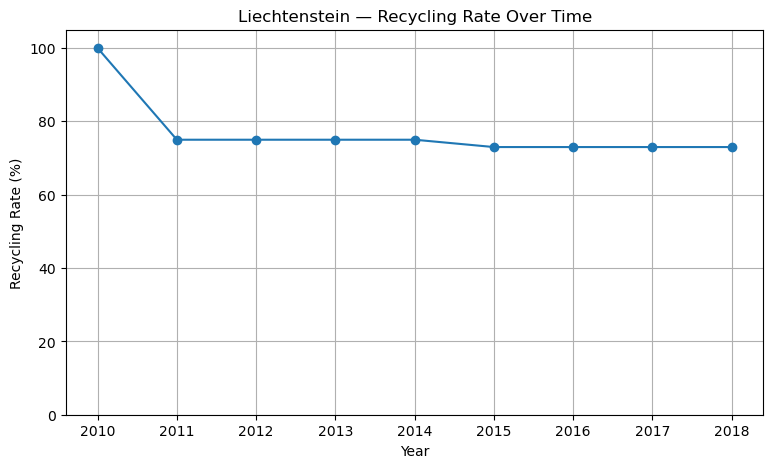

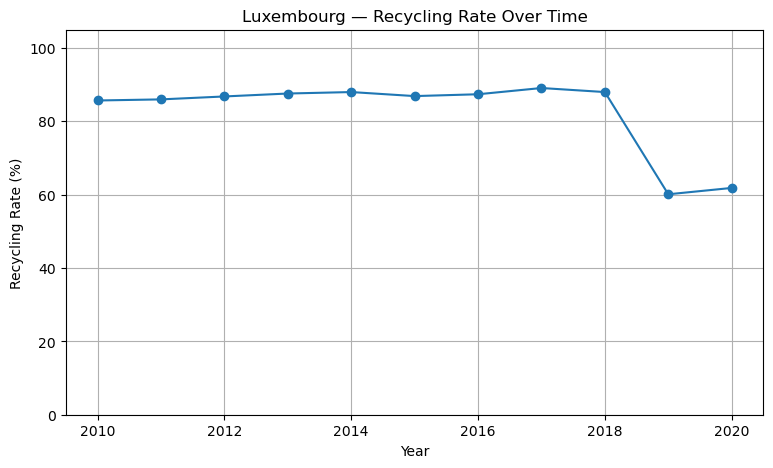

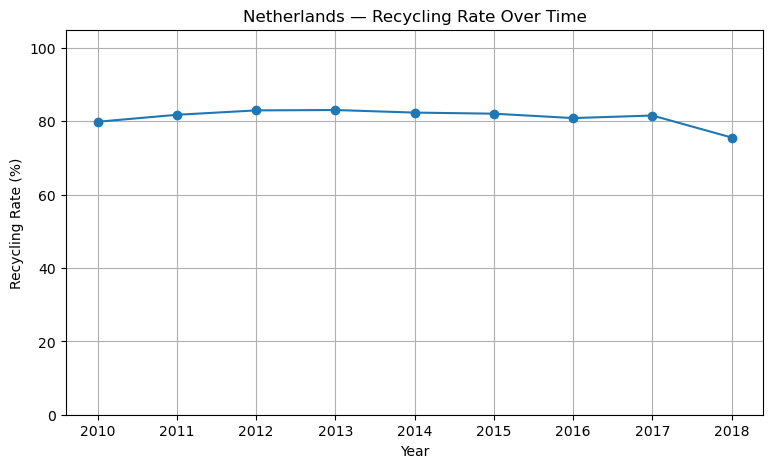

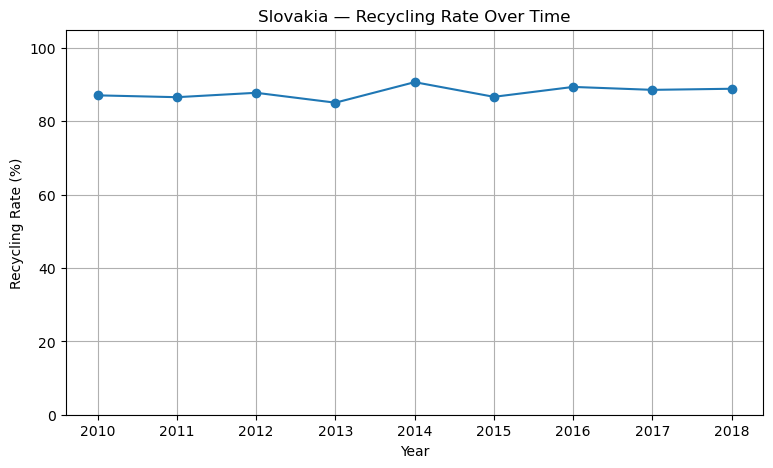

In [18]:
# Pick top-5 and bottom-5 at latest_common_year
top5_codes = latest.head(5)["country_code"].tolist()
bot5_codes = latest.tail(5)["country_code"].tolist()
subset_codes = top5_codes + bot5_codes

subset = panel[panel["country_code"].isin(subset_codes)].copy()

# Line plot per country
for ccode in subset["country_code"].unique():
    sub = subset[subset["country_code"] == ccode].sort_values("year")
    plt.figure()
    plt.plot(sub["year"], sub["ewaste_recycling_rate_pct"], marker="o")
    plt.title(f"{sub['country'].iloc[0]} — Recycling Rate Over Time")
    plt.xlabel("Year")
    plt.ylabel("Recycling Rate (%)")
    plt.ylim(0, max(100, subset['ewaste_recycling_rate_pct'].max() + 5))
    plt.grid(True)
    plt.show()


Across the top-performing countries (Austria, Finland, Croatia, Slovakia, and the Netherlands), recycling rates are consistently high throughout the 2010s, generally ranging between 80–95%. These countries show only minor year-to-year variation, indicating stable and mature collection and processing systems. Croatia and Finland stand out for consistently maintaining very high rates, while Austria shows a slightly flatter but steady pattern. These stability patterns suggest strong infrastructure, long-standing producer responsibility schemes, and public familiarity with recycling systems.
Belgium and France sit slightly lower among the leaders, maintaining rates in the 75–85% range with gradual and moderate fluctuations. France shows a small upward trend through 2016–2017 before a decline in 2018, which may reflect reporting method updates rather than a real shift in performance.
Among laggards, Iceland and Luxembourg show greater volatility. Iceland begins at a lower level (~67%) but improves markedly over time, reaching ~90% by 2018–2020 — suggesting capacity building or policy improvements in mid-decade. Luxembourg, on the other hand, remains high (>85%) until a sharp drop in 2019, which likely reflects data coverage/reporting artifacts rather than an abrupt real-world system change.
Liechtenstein shows a steep decline from 2010 to 2011 (100%→75%) followed by a long period of stability around ~73–75%, which again suggests reporting standard changes or small-population measurement sensitivity. The Netherlands shows a slight downward drift over time, suggesting either plateauing system performance or shifts in how “e-waste collected” is defined.
Overall, the leader group maintains high and stable recycling performance, while the laggard group exhibits either gradual improvement (Iceland) or reporting-driven variability (Luxembourg, Liechtenstein). These patterns imply that policy maturity, program age, national coordination, and population scale play meaningful roles in sustaining e-waste recycling outcomes.


## 6) Relationships: GDP per Capita vs Recycling
We create `gdp_per_capita` and examine correlation with the recycling rate. This addresses the rubric's requirement to use statistical methods to evaluate relationship strengths.


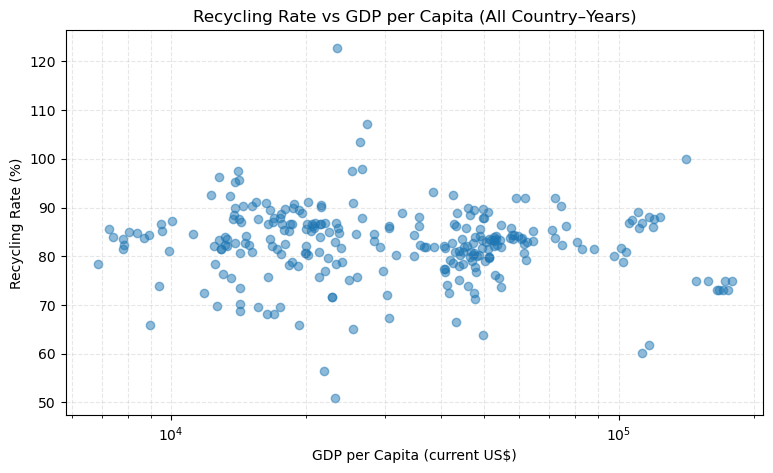

Pearson r (recycling %, GDP per capita): -0.125


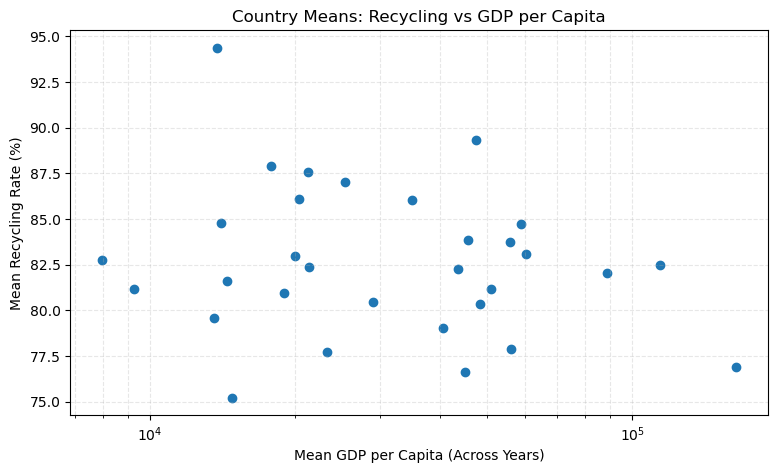

Pearson r (country means): -0.251


In [17]:
# Create GDP per capita
panel['gdp_per_capita'] = panel['gdp_current_usd'] / panel['population']

# Scatter (one point per country–year)
plt.figure()
plt.scatter(panel['gdp_per_capita'], panel['ewaste_recycling_rate_pct'], alpha=0.5)
plt.xlabel("GDP per Capita (current US$)")
plt.ylabel("Recycling Rate (%)")
plt.title("Recycling Rate vs GDP per Capita (All Country–Years)")
plt.xscale("log")  # log scale often clarifies spread
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

# Pearson correlation
corr = panel[['ewaste_recycling_rate_pct', 'gdp_per_capita']].dropna().corr().iloc[0,1]
print(f"Pearson r (recycling %, GDP per capita): {corr:.3f}")


# Optional: aggregate by country (mean across years) to reduce temporal noise
country_mean = (panel.groupby(['country_code','country'])
                .agg(recycling_mean=('ewaste_recycling_rate_pct','mean'),
                     gdp_pc_mean=('gdp_per_capita','mean'))
                .reset_index())

plt.figure()
plt.scatter(country_mean['gdp_pc_mean'], country_mean['recycling_mean'])
plt.xlabel("Mean GDP per Capita (Across Years)")
plt.ylabel("Mean Recycling Rate (%)")
plt.title("Country Means: Recycling vs GDP per Capita")
plt.xscale("log")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

corr_country = country_mean[['recycling_mean','gdp_pc_mean']].corr().iloc[0,1]
print(f"Pearson r (country means): {corr_country:.3f}")


There is a weak negative correlation between GDP per capita and recycling rate. Wealthier countries do not necessarily recycle more e-waste. Instead, strong policy design and well-organized collection systems explain high performance.

## 7) Inferential Questions & Hypotheses 
The exploratory analysis shows a weak negative relationship between GDP per capita and e-waste recycling rates. To determine whether this pattern is statistically meaningful rather than random variation, we can frame the following hypothesis test:
Null hypothesis (H₀): GDP per capita has no association with e-waste recycling rate.
Alternative hypothesis (H₁): GDP per capita has a systematic association with e-waste recycling rate.
A Pearson correlation test or a simple regression model could be used to formally evaluate this relationship.
Given the observed negative correlations (approximately –0.13 across individual country-years and –0.25 when averaged per country), rejecting H₀ would suggest that higher income does not predict stronger recycling outcomes, and that policy design and system structure play a more important role than economic capacity.

Additional Hypotheses to Explore Later (as part of extended analysis)
Regional Comparison:
Compare recycling rates between groups of countries, such as Nordic countries versus the rest of Europe.
This could test whether countries with long-established producer responsibility systems consistently outperform others.
Policy Timing Effects:
Examine whether recycling rates change before vs. after key EU policy events (e.g., major updates to the WEEE Directive).
A before/after comparison could indicate whether policy changes lead to measurable improvements.
System Stability:
Evaluate whether high-performing countries also show less year-to-year variation (i.e., more stable recycling systems), compared to lower-performing countries.
Data Robustness Check:
Restrict analysis to countries with at least 8 years of observations to avoid patterns driven by sparse reporting rather than true performance differences.


## 8) Feature Selection & Engineering 
The primary outcome variable is ewaste_recycling_rate_pct, which measures the percentage of e-waste collected and recycled. Based on the EDA, several features are candidates for explaining variation across countries and over time:
gdp_per_capita as a broad proxy for national economic capacity.
However, given the weak and slightly negative correlation, it will be treated as contextual rather than a primary explanatory driver.
Regional grouping (e.g., Nordic, Western, Southern, Eastern Europe) to capture shared policy frameworks, cultural recycling norms, and institutional maturity.
This may be more meaningful than GDP alone.
year or time index, to capture global policy changes, EU directive phases, and general recycling system scaling.
Lagged recycling rate (e.g., recycling_rate_{t-1}) to model persistence: recycling systems evolve slowly and past performance strongly predicts current performance.
Coverage / reporting stability indicator, to account for years with missing or partial national reporting, which can otherwise distort trends.
Feature Engineering Approaches:
Lag features: Adding a lagged recycling rate helps capture system momentum. This is especially relevant if modeling change within individual countries.
Within-country standardization (demeaning): Removing country-level averages allows analysis of changes over time rather than cross-country levels, which helps isolate policy shifts from structural differences.
Transformation: GDP per capita is right-skewed; using log GDP per capita or standardized GDP facilitates more stable modeling interpretation.
Optional scaling: If using regression or distance-based models later, standardizing features will be applied.
Design Decision (Current Scope):
Since this stage focuses on descriptive and comparative analysis rather than predictive modeling, the emphasis will be on:
Latest recycling performance levels
Change since 2010 (or earliest available year)
Regional model differences
GDP per capita only as interpretive background, not a primary driver
The feature engineering work above sets a clear path for later inferential or predictive modeling, should that be part of the next phase.


**Summary**: This exploratory analysis examined e-waste recycling performance across European countries from 2010 to 2022, using standardized percentage-based recycling rates supplemented with population and GDP context. At the EU level, recycling performance remained relatively stable over the decade, generally ranging between 80–85%, with the population-weighted rate consistently below the simple average. This indicates that larger countries tend to have slightly lower recycling rates, while many smaller nations help pull the average upward. A sharp dip around 2019 appears linked to reporting or classification differences rather than a sudden system-wide decline, emphasizing the importance of coverage awareness when interpreting time-series data.
Country-level patterns show clear performance differentiation. Leaders such as Finland, Croatia, Slovakia, and Austria maintain high and stable recycling rates, reflecting mature collection infrastructures and strong producer responsibility frameworks. In contrast, countries like Iceland and Luxembourg show greater volatility, either due to late adoption of structured systems or small-population reporting sensitivity. These trends suggest that institutional and regulatory maturity, rather than economic capacity alone, drive sustained performance.
The relationship between GDP per capita and recycling rate is weakly negative, meaning wealthier countries do not necessarily recycle more e-waste. Instead, system design, enforcement of collection obligations, and public participation norms appear to be more influential. This finding supports shifting the analytical focus toward regional policy models, historical system development, and within-country change over time, rather than assuming that economic resources determine recycling success.
Overall, the EDA provides a strong foundation for the next phase of the project. Future analysis will focus on grouping countries by policy or regional model, examining change since baseline years, and incorporating lagged behavior to capture system persistence. These patterns will guide which features are most meaningful for explaining variation in e-waste recycling outcomes across Europe.